# <a id='toc1_'></a>[Classifying Thyroid Cancer using Neural Networks](#toc0_)

## <a id='toc1_1_'></a>[Abstract](#toc0_)

This notebook demonstrates a simple machine learning pipeline used to classify thyroid cancers from numerical data. The dataset is sourced from kaggle, and I apply a binary classifier neural network to the dataset to predict whether a tumour is benign or malignant. I then compare the performance of these neural networks with other models that have been applied to this dataset. We see the produced model has comparable accuracy but is prone to false negatives, a major concern in a medical setting. Therefore, further work is needed to refine this including sourcing new features for the dataset.

## <a id='toc1_2_'></a>[Learning Outcomes](#toc0_)

By following this notebook, the reader should be able to:

- Import a dataset from Kaggle using the Kagglehub library and the Pandas adapter
- Validate data integrity
- Preprocess data (encode and normalise)
- Visualise relations between features and classes
- Analyse the effect of network architecture, optimiser and hyperparameters on network performance
- Define and train a neural network using findings from the previous step
- Visualise results and accuracy of the trained model

Whilst this notebook is novel in applying neural networks to this dataset and provides a framework that is easy to expand upon, it is important to highlight what this notebook does not aim to achieve:

- In-depth data analysis. Other tutorials for this dataset on Kaggle already cover this area [1],[2]
- Optimising model performance. Whilst this tutorial takes a naive approach to this subject, it doesn't cover it in depth. For this area, I recommend reading [3] for an overview of optimising classifiers for higher accuracy
- In-depth data preprocessing. For reference on how to do this, I recommend Miami University's Data Cleaning Tutorial [4].
- Performing feature engineering. See [5] for this subject
- Comparison of encoding methods on model performance. For an overview of encoding methods, I recommend [6]
- Performing cross-validation and comparing models with rigorous statistical analysis


## Contents<a id='toc0_'></a>    
- [Classifying Thyroid Cancer using Neural Networks](#toc1_)    
  - [Abstract](#toc1_1_)    
  - [Learning Outcomes](#toc1_2_)    
  - [](#toc1_3_)    
  - [Methodology](#toc1_4_)    
    - [Introduction](#toc1_4_1_)    
    - [Data Analysis](#toc1_4_2_)    
    - [Data Preprocessing](#toc1_4_3_)    
    - [Training](#toc1_4_4_)    
      - [Analysing the effect of network structure on performance](#toc1_4_4_1_)    
      - [Analysing the effect of optimisers on performance](#toc1_4_4_2_)    
      - [Analysing the effect of changing learning rate on performance](#toc1_4_4_3_)    
    - [Alternative Models](#toc1_4_5_)    
  - [Discussion](#toc1_5_)    
  - [ References](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_4_'></a>[Methodology](#toc0_)

This section covers the entire implementation of classification, from downloading the dataset to evaluating our trained model's performance on a subset of the data.

### <a id='toc1_4_1_'></a>[Introduction](#toc0_)

However, before getting started, there are a few steps we must first complete. Some of the code snippets taken from Kaggle require the Pandas adaptor for Kagglehub which isn't available via Conda. The following cells install this, as well as importing all modules needed for the notebook:

In [1]:
! pip install "kagglehub[pandas-datasets]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 15.5 MB/s eta 0:00:0000:010:01


In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

Next, we define the device that pytorch will use to train our model later. If you have access to an NVIDIA GPU, you can swap this to CUDA for *possibly* faster training (note: this isn't what I experienced, and the CPU is adequately fast enough as the model is very small, however this information should be kept in mind if adjusting to a larger model and training time becomes too large)

In [64]:
# Code from [7]
device = "cpu"
print(f"Using {device} device")
torch.set_default_device(device)
# End of source [7]

Using cpu device


### <a id='toc1_4_2_'></a>[Data Analysis](#toc0_)

We now load the "Thyroid Cancer Risk" dataset from Kaggle using Kagglehub and the Kagglehub Pandas adaptor and save it to the variable ```df```. The dataset includes a Patient_ID column, which has no statistical significance with the record's class and simply acts as an identifier value. For this reason, it is dropped from the dataset before continuing to the following stages. We then can see an overview of the data in the Pandas DataFrame:

In [65]:
# Dataset and code as from [8]
file_path = "thyroid_cancer_risk_data.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "bhargavchirumamilla/thyroid-cancer-risk-dataset",
  file_path,
)
# End of source [8]

# Remove unnecassary column
df = df.drop(columns="Patient_ID")
df


Age  Gender  Country       Ethnicity Family_History  \
0        66    Male   Russia       Caucasian             No   
1        29    Male  Germany        Hispanic             No   
2        86    Male  Nigeria       Caucasian             No   
3        75  Female    India           Asian             No   
4        35  Female  Germany         African            Yes   
...     ...     ...      ...             ...            ...   
212686   58  Female    India           Asian             No   
212687   89    Male    Japan  Middle Eastern             No   
212688   72  Female  Nigeria        Hispanic             No   
212689   85  Female   Brazil  Middle Eastern             No   
212690   46  Female    Japan  Middle Eastern             No   

       Radiation_Exposure Iodine_Deficiency Smoking Obesity Diabetes  \
0                     Yes                No      No      No       No   
1                     Yes                No      No      No       No   
2                      No                No      No      No       No   
3                      No                No      No      No       No   
4                     Yes                No      No      No       No   
...                   ...               ...     ...     ...      ...   
212686                 No                No      No     Yes       No   
212687                 No                No      No     Yes       No   
212688                 No                No      No      No      Yes   
212689                 No                No      No      No      Yes   
212690                 No                No     Yes      No       No   

        TSH_Level  T3_Level  T4_Level  Nodule_Size Thyroid_Cancer_Risk  \
0            9.37      1.67      6.16         1.08                 Low   
1            1.83      1.73     10.54         4.05                 Low   
2            6.26      2.59     10.57         4.61                 Low   
3            4.10      2.62     11.04         2.46              Medium   
4            9.10      2.11     10.71         2.11                High   
...           ...       ...       ...          ...                 ...   
212686       2.00      0.64     11.92         1.48                 Low   
212687       9.77      3.25      7.30         4.46              Medium   
212688       7.72      2.44      8.71         2.36              Medium   
212689       5.62      2.53      9.62         1.54              Medium   
212690       5.60      2.73     10.59         2.53                 Low   

        Diagnosis  
0          Benign  
1          Benign  
2          Benign  
3          Benign  
4          Benign  
...           ...  
212686     Benign  
212687     Benign  
212688     Benign  
212689     Benign  
212690  Malignant  

[212691 rows x 16 columns]

We must next ensure that there are no missing values in our dataset. To do this, we use DataFrame.isnull() and sum these values using numpy.sum(). As you can see, this dataset is somewhat unrealistic and does not have any missing values.

In [66]:
np.sum(df.isnull(), axis=0)

Age                    0
Gender                 0
Country                0
Ethnicity              0
Family_History         0
Radiation_Exposure     0
Iodine_Deficiency      0
Smoking                0
Obesity                0
Diabetes               0
TSH_Level              0
T3_Level               0
T4_Level               0
Nodule_Size            0
Thyroid_Cancer_Risk    0
Diagnosis              0
dtype: int64

Not all features are equal so to visualise their relationship with the label, we group cancer risk levels against diagnosis and perform a Chi-squared test on all features.

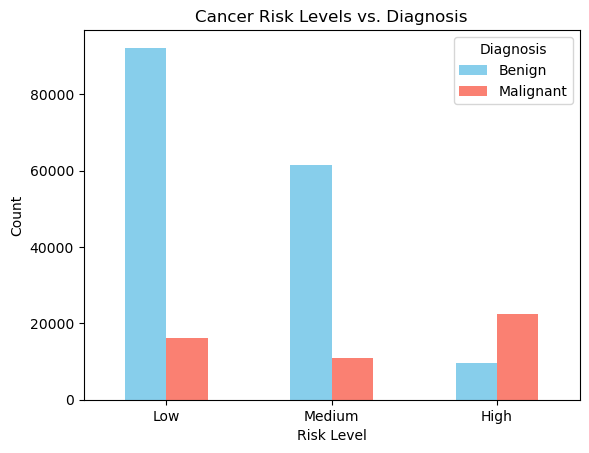

In [67]:
# Enforce this to be a categorical column so the order displayed in the plot is correct
df['Thyroid_Cancer_Risk'] = pd.Categorical(df['Thyroid_Cancer_Risk'], categories=['Low', 'Medium', 'High'], ordered=True)

counts = df.groupby(['Thyroid_Cancer_Risk', 'Diagnosis'], observed=False)["Diagnosis"].count().unstack()
counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.title('Cancer Risk Levels vs. Diagnosis')
plt.xticks(rotation=0)
plt.legend(title='Diagnosis')

The dataset includes the following categorical data columns: "Gender", "Country", "Ethnicity", "Family_History", "Radiation_Exposure", "Iodine_Deficiency", "Smoking", "Obesity", "Diabetes", "Thyroid_Cancer_Risk", "Diagnosis". To analyse these and later use them in a neural network, we must encode these values. For simplicity's sake, and keeping the dimensionality of the dataset low, these columns are all encoded using Sci-kit Learn's Label encoder. The process and the output can be seen below:

In [68]:
#Encode data
le = LabelEncoder()
encoded_df = df.copy()

columns = ["Gender", "Country", "Ethnicity", "Family_History", "Radiation_Exposure", "Iodine_Deficiency", "Smoking", "Obesity", "Diabetes", "Thyroid_Cancer_Risk", "Diagnosis"]

for column in columns:
  encoded_df[column] = le.fit_transform(df[column])

encoded_df

Age  Gender  Country  Ethnicity  Family_History  Radiation_Exposure  \
0        66       1        6          2               0                   1   
1        29       1        2          3               0                   1   
2        86       1        5          2               0                   0   
3        75       0        3          1               0                   0   
4        35       0        2          0               1                   1   
...     ...     ...      ...        ...             ...                 ...   
212686   58       0        3          1               0                   0   
212687   89       1        4          4               0                   0   
212688   72       0        5          3               0                   0   
212689   85       0        0          4               0                   0   
212690   46       0        4          4               0                   0   

        Iodine_Deficiency  Smoking  Obesity  Diabetes  TSH_Level  T3_Level  \
0                       0        0        0         0       9.37      1.67   
1                       0        0        0         0       1.83      1.73   
2                       0        0        0         0       6.26      2.59   
3                       0        0        0         0       4.10      2.62   
4                       0        0        0         0       9.10      2.11   
...                   ...      ...      ...       ...        ...       ...   
212686                  0        0        1         0       2.00      0.64   
212687                  0        0        1         0       9.77      3.25   
212688                  0        0        0         1       7.72      2.44   
212689                  0        0        0         1       5.62      2.53   
212690                  0        1        0         0       5.60      2.73   

        T4_Level  Nodule_Size  Thyroid_Cancer_Risk  Diagnosis  
0           6.16         1.08                    1          0  
1          10.54         4.05                    1          0  
2          10.57         4.61                    1          0  
3          11.04         2.46                    2          0  
4          10.71         2.11                    0          0  
...          ...          ...                  ...        ...  
212686     11.92         1.48                    1          0  
212687      7.30         4.46                    2          0  
212688      8.71         2.36                    2          0  
212689      9.62         1.54                    2          0  
212690     10.59         2.53                    1          1  

[212691 rows x 16 columns]

                Feature    Chi2 Stat       P-value
14  Thyroid_Cancer_Risk  9608.660813  0.000000e+00
4        Family_History  2956.299276  0.000000e+00
3             Ethnicity  1990.222073  0.000000e+00
6     Iodine_Deficiency  1565.973944  0.000000e+00
5    Radiation_Exposure  1433.738538  0.000000e+00
2               Country   161.814823  4.540931e-37
10            TSH_Level     2.458406  1.168974e-01
9              Diabetes     1.761771  1.844038e-01
13          Nodule_Size     1.252263  2.631206e-01
11             T3_Level     0.454651  5.001344e-01
1                Gender     0.264209  6.072430e-01
8               Obesity     0.226356  6.342394e-01
12             T4_Level     0.178488  6.726762e-01
7               Smoking     0.126405  7.221894e-01
0                   Age     0.025448  8.732552e-01


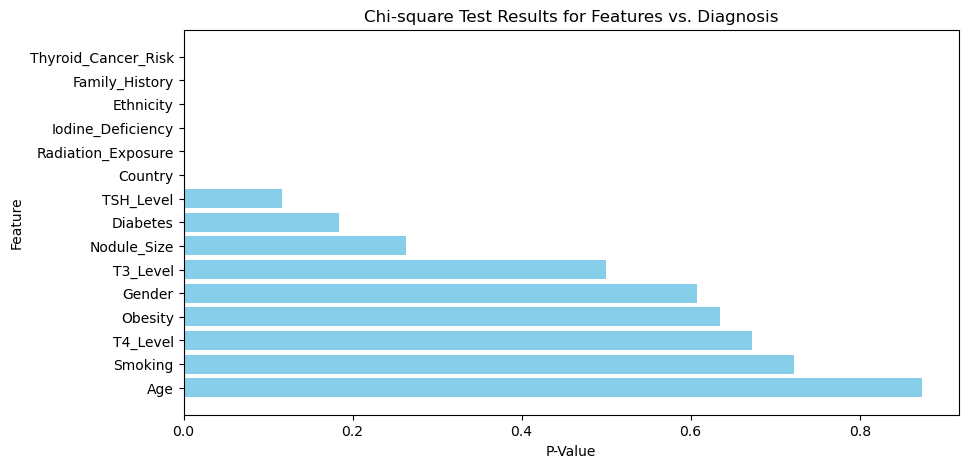

In [69]:
# Code from [9]
X = encoded_df.drop(columns=['Diagnosis'])
y = encoded_df['Diagnosis']
chi2_stats, p_values = chi2(X, y)
# End of source [9]

chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2 Stat': chi2_stats, 'P-value': p_values})
chi2_df = chi2_df.sort_values(by='Chi2 Stat', ascending=False)

print(chi2_df)

# Plot results
plt.figure(figsize=(10, 5))
plt.barh(chi2_df['Feature'], chi2_df['P-value'], color='skyblue')
plt.xlabel("P-Value")
plt.ylabel("Feature")
plt.title("Chi-square Test Results for Features vs. Diagnosis")
plt.gca().invert_yaxis()
plt.show()


As you can see, the factors with the highest correlations to diagnosis type (in order) are:
- Thyroid Cancer Risk
- Family History
- Ethnicity
- Iodine-Deficiency
- Radiation_Exposure
- Country

We can argue, with a certain level of confidence, that factors such as nodule_size, gender, obesity and age have no statistical relevance on whether a thyroid cancer diagnosis is benign or malignant. However, we will still use these values in our models.

### <a id='toc1_4_3_'></a>[Data Preprocessing](#toc0_)
Next, we split the data into features and labels, normalise the features, and then split both the features and labels into training and testing sets, stratifying the split over the label classes so that each class is proportionally represented in the splits.

In [70]:
scaler = MinMaxScaler()

# Normalize the DataFrame
normalised_df = pd.DataFrame(scaler.fit_transform(encoded_df), columns=encoded_df.columns)

features = encoded_df.drop(columns=["Diagnosis"])
normalised_features = scaler.fit_transform(features)
labels = encoded_df["Diagnosis"].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(normalised_features, labels, stratify=labels, test_size=0.2)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### <a id='toc1_4_4_'></a>[Training](#toc0_)


Here, we define a class to build our models. The class is used to define a neural network and takes the name, layers, criterion, optimiser_class and optimiser_kwargs as parameters. The class provides methods for training the model based on input and output data, as well as evaluation against test data. This makes the process of training multiple models and comparing their accuracies easier, reduces duplicated code, and makes the pipeline easier to expand with more models.

In [71]:
#Code from [10]
class NeuralNetwork(torch.nn.Module):
  def __init__(self, name, layers, criterion, optimiser_class, optimiser_kwargs):
    super().__init__()
    self.name = name
    self.flatten = torch.nn.Flatten()
    self.connected_layers = layers
    self.criterion = criterion
    self.optimiser = optimiser_class(self.parameters(), **optimiser_kwargs)
    self.losses = []
    self.accuracies = []

  def forward(self, x):
    x = self.flatten(x)
    output = self.connected_layers(x)
    return output
  
# End of source [10]


# Start of source [11]
  def backward(self, y_pred, y_train):
    self.optimiser.zero_grad()
    loss = self.criterion(y_pred.squeeze(), y_train)
    self.losses.append(loss.item())
    # Start of source [12]
    accuracy = (y_pred.squeeze().round() == y_train).float().mean()
    self.accuracies.append(accuracy.item())
    # End of source [12]
    loss.backward()
    self.optimiser.step()
    return loss

  def train(self, x, y, epochs):
    print(f"Training {self.name}")
    for epoch in range(0, epochs):
      y_pred = self.forward(x)
      self.backward(y_pred, y)
    print(f"Done training {self.name} with a training accuracy of {self.accuracies[-1]}\n")
# End of source [11]

  def test(self, x, y):
    y_pred = self.forward(x)
    predicted_labels = (y_pred >= 0.5).float()
    self.test_accuracy = (predicted_labels.squeeze() == y).float().mean()
    self.test_cm = confusion_matrix(y_test, predicted_labels)

#### <a id='toc1_4_4_1_'></a>[Analysing the effect of network structure on performance](#toc0_)

Next, we define 4 neural networks for binary classification. Each one has a different network architecture but maintains the same optimisers and hyperparameters for consistency. From these networks, we will choose the one with the highest accuracy to progress to the next stage.
1. Model 1 - 1 layer with a sigmoid function to output the probability of a class. This layer contains 1 node and takes 16 inputs (the number of features in the dataset). This is then fed into the Sigmoid function as the activation function to produce a value between 0 and 1 which is used for the binary classification process. Essentially, this is a single perceptron.
2. Model 2 - 2 layers. The first layer consists of 5 nodes using ReLU as their activation function. The second layer is a single node for output (the same as Model 1) This is to see the effect of changing the depth of the model.
3. Model 3 - 2 layers. The first layer consists of 20 nodes using ReLU as their activation function. The second layer is a single node for output again. 
4. Model 4 - 3 layers. The first layer consists of 20 nodes using ReLU. The second layer contains 10 nodes using ReLU, and the third layer is a single output node.


In [72]:
INPUT_SIZE = x_train_tensor.shape[1]

networks = [
    NeuralNetwork(
        name="[1]",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = torch.optim.Adam,
        optimiser_kwargs = {"lr": 0.01}
      ),
    NeuralNetwork(
        name="[5, 1]",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = torch.optim.Adam,
        optimiser_kwargs = {"lr": 0.01}
      ),
    NeuralNetwork(
        name="[20, 1]",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = torch.optim.Adam,
        optimiser_kwargs = {"lr": 0.01}
      ),
    NeuralNetwork(
        name="[20, 10, 1]",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = torch.optim.Adam,
        optimiser_kwargs = {"lr": 0.01}
      ),
    ]

In [73]:
# Train networks and collect training data
for network in networks:
    network.train(x_train_tensor, y_train_tensor, 500)

Training [1]
Done training [1] with a training accuracy of 0.8105693459510803

Training [5, 1]
Done training [5, 1] with a training accuracy of 0.8206956386566162

Training [20, 1]
Done training [20, 1] with a training accuracy of 0.8270781636238098

Training [20, 10, 1]
Done training [20, 10, 1] with a training accuracy of 0.8270781636238098



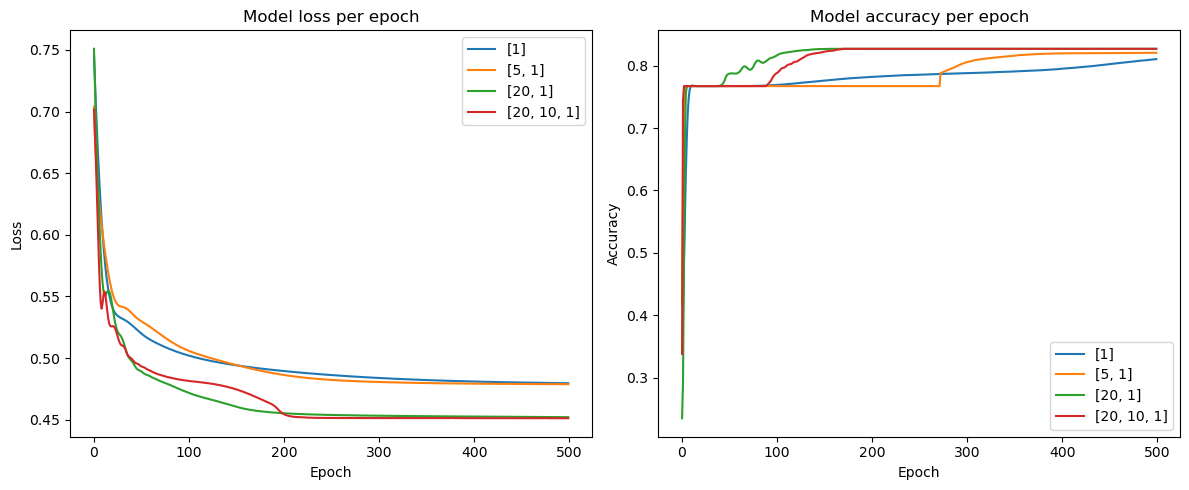

In [74]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss and accuracy curves
for network in networks:
    axes[0].plot(network.losses, label=network.name)
    axes[1].plot(network.accuracies, label=network.name)

axes[0].set_title("Model loss per epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Model accuracy per epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

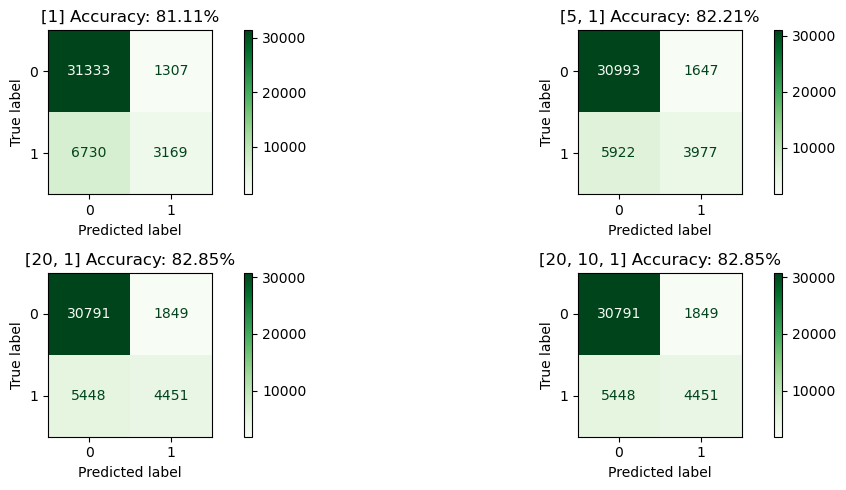

In [75]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
axes = axes.flatten()

with torch.no_grad():
    for i, network in enumerate(networks):
        network.test(x_test_tensor, y_test_tensor)
        disp_1 = ConfusionMatrixDisplay(confusion_matrix=network.test_cm)
        disp_1.plot(ax=axes[i], cmap="Greens")
        axes[i].set_title(f"{network.name} Accuracy: {round(network.test_accuracy.item() * 100, 2)}%")

plt.tight_layout()
plt.show()

Model 1 achieves both the lowest training and test accuracies, with Models 3, and 4  achieving the same accuracy in training and testing. However, depending on the split of training and data, model 2 can also achieve the same performance (this can be observed by running the notebook again). From these results, we can deduce that increasing network depth or width beyond the architecture specified by Model 2 improves the reproducibility of the network performance, however, this improvement is still bounded; \[20, 10, 1] architecture does not improve upon \[20, 1] and takes longer to train. Therefore, all the following models will implement Model 3's architecture.

#### <a id='toc1_4_4_2_'></a>[Analysing the effect of optimisers on performance](#toc0_)

Next, we define 4 neural networks for binary classification. Each one uses Model 2's architecture from the previous section. Here, we analyse the effect of using different optimisers to train our models.
1. Model 1 - Uses the SGD optimiser
2. Model 2 - Uses Adam optimiser
3. Model 3 - Uses Adamax optimiser 
4. Model 4 - Uses RMSprop optimser


In [90]:
networks_2 = [
    NeuralNetwork(
        name="SGD",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = torch.optim.SGD,
        optimiser_kwargs = {"lr": 0.01}
      ),
    NeuralNetwork(
        name="Adam",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = torch.optim.Adam,
        optimiser_kwargs = {"lr": 0.01}
      ),
    NeuralNetwork(
        name="Adamax",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = torch.optim.Adamax,
        optimiser_kwargs = {"lr": 0.01}
      ),
    NeuralNetwork(
        name="RMSprop",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = torch.optim.RMSprop,
        optimiser_kwargs = {"lr": 0.01}
      ),
    ]

In [91]:
# Train networks and collect training data
for network in networks_2:
    network.train(x_train_tensor, y_train_tensor, 500)

Training SGD
Done training SGD with a training accuracy of 0.7672904133796692

Training Adam
Done training Adam with a training accuracy of 0.8270781636238098

Training Adamax
Done training Adamax with a training accuracy of 0.8270781636238098

Training RMSprop
Done training RMSprop with a training accuracy of 0.8270781636238098



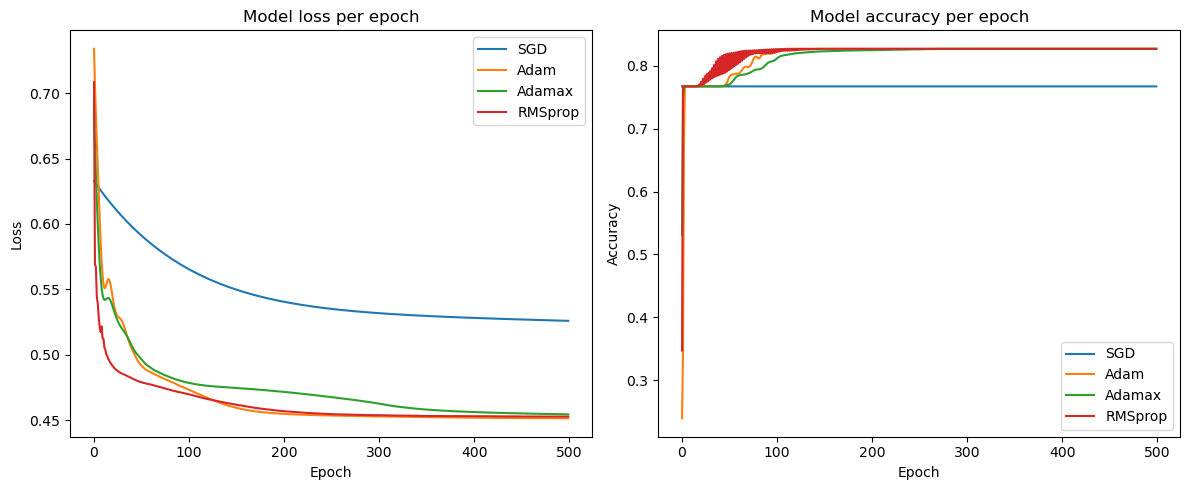

In [89]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss and accuracy curves
for network in networks_2:
    axes[0].plot(network.losses, label=network.name)
    axes[1].plot(network.accuracies, label=network.name)

axes[0].set_title("Model loss per epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Model accuracy per epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

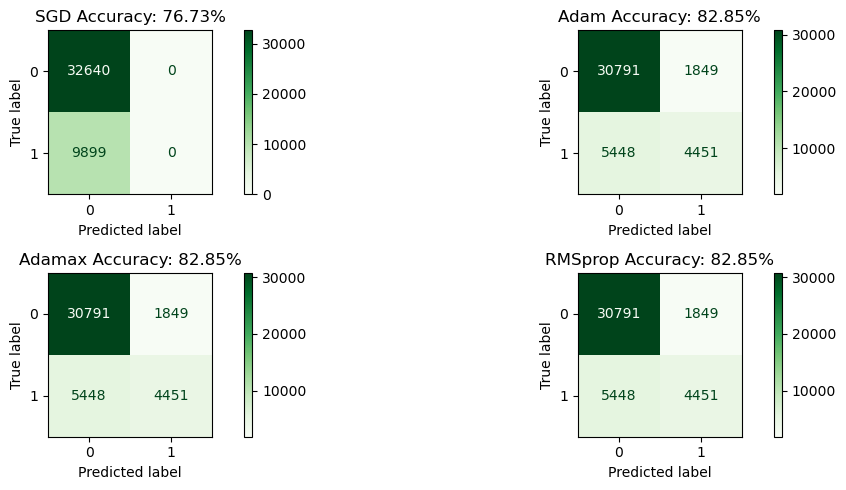

In [92]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
axes = axes.flatten()

with torch.no_grad():
    for i, network in enumerate(networks_2):
        network.test(x_test_tensor, y_test_tensor)
        disp_1 = ConfusionMatrixDisplay(confusion_matrix=network.test_cm)
        disp_1.plot(ax=axes[i], cmap="Greens")
        axes[i].set_title(f"{network.name} Accuracy: {round(network.test_accuracy.item() * 100, 2)}%")

plt.tight_layout()
plt.show()

SGD performed the worst out of all optimisers, with all other optimisers achieving similar or identical training and test accuracies. However, from this, I interpret Adam to be the best optimiser because it achieved high accuracy quicker than the other optimisers. From this point onwards, the models will now use Model 2's architecture with the Adam optimiser.

In [93]:
OPTIMISER = torch.optim.Adam

#### <a id='toc1_4_4_3_'></a>[Analysing the effect of changing learning rate on performance](#toc0_)

Next, we define 4 neural networks for binary classification. Each uses Model 2's architecture and the AdaMax optimiser but adjusts the learning rate. The network with the highest accuracy will be selected as the final model.
1. Model 1 - Learning rate of 1
2. Model 2 - Learning rate of 0.1
3. Model 3 - Learning rate of 0.01 
4. Model 4 - Learning rate of 0.001

In [96]:
networks_3 = [
    NeuralNetwork(
        name="1",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = OPTIMISER,
        optimiser_kwargs = {"lr": 1}
      ),
    NeuralNetwork(
        name="0.1",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = OPTIMISER,
        optimiser_kwargs = {"lr": 0.1}
      ),
    NeuralNetwork(
        name="0.01",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = OPTIMISER,
        optimiser_kwargs = {"lr": 0.01}
      ),
    NeuralNetwork(
        name="0.001",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimiser_class = OPTIMISER,
        optimiser_kwargs = {"lr": 0.001}
      ),
    ]

In [97]:
# Train networks and collect training data
for network in networks_3:
    network.train(x_train_tensor, y_train_tensor, 500)

Training 1
Done training 1 with a training accuracy of 0.7672904133796692

Training 0.1
Done training 0.1 with a training accuracy of 0.8270781636238098

Training 0.01
Done training 0.01 with a training accuracy of 0.8270781636238098

Training 0.001
Done training 0.001 with a training accuracy of 0.7940723299980164



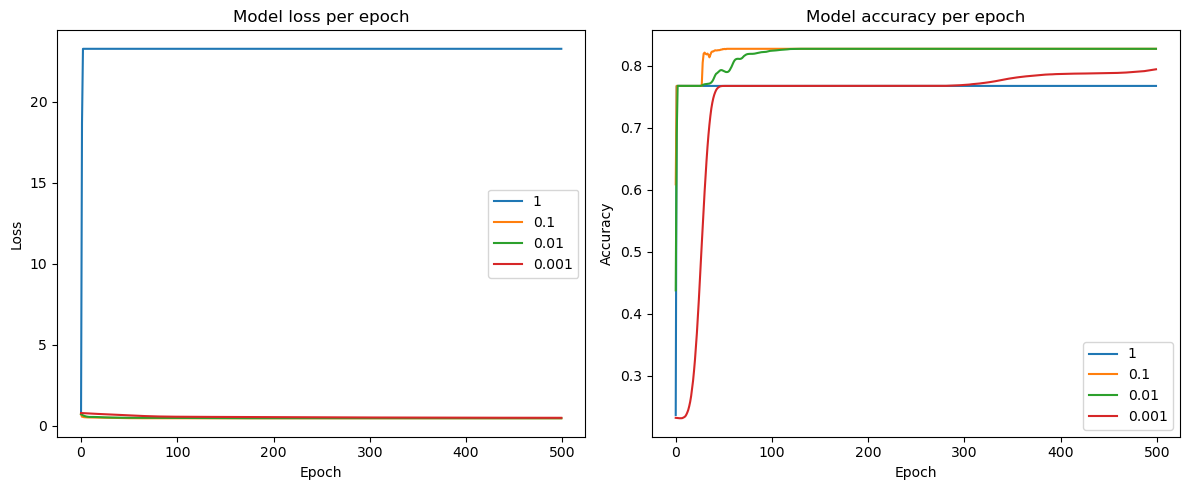

In [98]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss and accuracy curves
for network in networks_3:
    axes[0].plot(network.losses, label=network.name)
    axes[1].plot(network.accuracies, label=network.name)

axes[0].set_title("Model loss per epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Model accuracy per epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

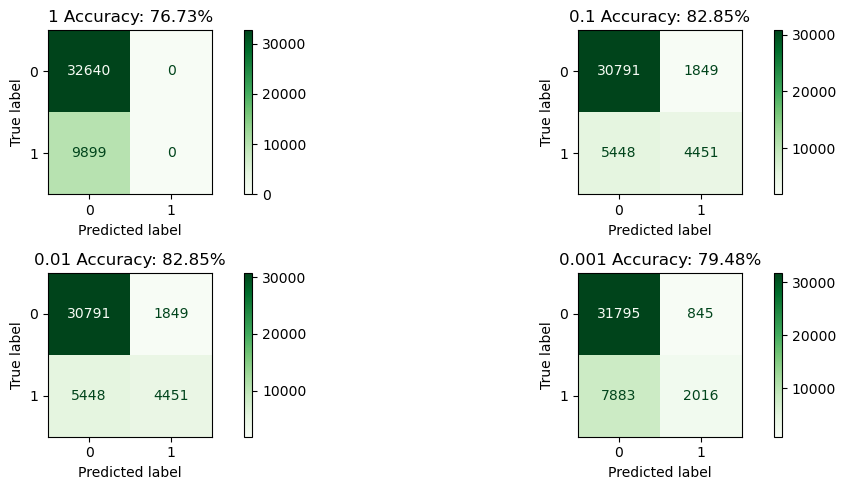

In [99]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
axes = axes.flatten()

with torch.no_grad():
    for i, network in enumerate(networks_3):
        network.test(x_test_tensor, y_test_tensor)
        disp_1 = ConfusionMatrixDisplay(confusion_matrix=network.test_cm)
        disp_1.plot(ax=axes[i], cmap="Greens")
        axes[i].set_title(f"{network.name} Accuracy: {round(network.test_accuracy.item() * 100, 2)}%")

plt.tight_layout()
plt.show()

A learning rate of 1 failed to reduce training loss over each epoch, meaning it is too high. Interestingly though, it still achieved a relatively high accuracy on the validation data due to the large number of benign diagnoses in the data. This means we should also consider other performance metrics in the analysis of the final model. 

0.1 and 0.01 achieve identical accuracies, but 0.1 reaches this maximum accuracy earlier than 0.01, meaning training could be faster if implementing an early stop algorithm. In the same vein, 0.001 failed to reach the same accuracy as other learning rates, likely needing a greater number of epochs to achieve the given accuracy. For this reason, the model using a learning rate of 0.1 will be used as the final benchmark.

### <a id='toc1_4_5_'></a>[Alternative Models](#toc0_)

In [13], the author uses a LogsticRegression and a RandomForestClassifier from sci-kit learn for their binary classification task. Indeed, all other tutorials for this dataset use LinearRegression, RandomForestClassifiers, XGBoost, SVMs and other models [1],[2]. However, none have applied neural networks to this dataset. To compare these, we will now implement these models.

In [101]:
# Start of source [13]
models = {
        'LogReg' : LogisticRegression(random_state=42, class_weight='balanced', max_iter=500),
        'RandomForest' : RandomForestClassifier(class_weight='balanced', random_state=42)
        }

for name, model, in models.items():
    model.fit(x_train, y_train)
    print(f"{name} - Accuracy: {model.score(x_test, y_test)}")
# End of source [13]

LogReg - Accuracy: 0.6829732715860739
RandomForest - Accuracy: 0.8256423517243


## <a id='toc1_5_'></a>[Discussion](#toc0_)

The model produced in this notebook (**\[20, 1] structure, Adam optimiser with a learning rate of 0.1**) achieved an accuracy of **82.85%** on the test data. This reflects the accuracies achieved by models in other tutorials [1],[2] for this dataset. However, the model produces a high rate of false negatives which is detrimental in a medical scenario. This is likely due to the low correlation of features to labels seen in the data analysis section for all features except "Cancer Risk", so sourcing extra features that have stronger correlations to the class label is important.

When compared with my implementation of some of the models commonly used for this dataset, a RandomForest model achieves comparable performance to the best neural networks produced in this notebook. However, it takes significantly longer to fit the model than to train my model, so it can be argued that for this reason, a neural network  is a more efficient model to apply. On the other hand, for medical diagnosis, the ability to follow the reasoning of a model is important and so because of this, a RandomForest model may be preferable. 

Further work is therefore needed to compare these models fully using cross-validation and T-tests, as well as sourcing new features to improve the performance of both models.

## <a id='toc1_6_'></a>[ References](#toc0_)
1. https://www.kaggle.com/code/sonawanelalitsunil/thyroid-cancer-risk-factors-and-prognosis-82-49
2. https://www.kaggle.com/code/debisree/thyroid-cancer
3. https://medium.com/foundational-data-science-interview-questions/five-tips-to-improve-your-binary-classification-modeling-d1568396063f
4. https://miamioh.edu/centers-institutes/center-for-analytics-data-science/students/coding-tutorials/python/data-cleaning.html
5. https://www.kaggle.com/code/ryanholbrook/what-is-feature-engineering
6. https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b
7. https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
8. https://www.kaggle.com/datasets/bhargavchirumamilla/thyroid-cancer-risk-dataset
9. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
10. https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
11. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
12. https://github.com/Prixis10/Breast-Cancer-Detection-Using-Pytorch/blob/main/breast_cancer_detection.ipynb
13. https://dataknowsall.com/blog/classification.html